### BF Analysis & Iso-Response Contours

In [1]:
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter
import tensorflow as tf
from data.dataset import Dataset
import data.data_selector as ds
import utils.data_processing as dp
import utils.plot_functions as pf
import analysis.analysis_picker as ap

In [3]:
class lca_params(object):
  def __init__(self):
    self.model_type = "lca"
    self.model_name = "lca_mnist"
    self.version = "0.0"
    self.save_info = "analysis"
    self.overwrite_analysis_log = False
  
class vae_params(object):
  def __init__(self):
    self.model_type = "vae"
    self.model_name = "vae_mnist"
    self.version = "0.0"
    self.save_info = "analysis"
    self.overwrite_analysis_log = False

lca_analysis_params = lca_params()
vae_analysis_params = vae_params()
# Computed params
lca_analysis_params.model_dir = (os.path.expanduser("~")+"/Work/Projects/"+lca_analysis_params.model_name)
vae_analysis_params.model_dir = (os.path.expanduser("~")+"/Work/Projects/"+vae_analysis_params.model_name)

In [4]:
lca_analyzer = ap.get_analyzer(lca_analysis_params.model_type)
lca_analyzer.setup(lca_analysis_params)
lca_analyzer.model.setup(lca_analyzer.model_params)
lca_analyzer.load_analysis(save_info=lca_analysis_params.save_info)

vae_analyzer = ap.get_analyzer(vae_analysis_params.model_type)
vae_analyzer.setup(vae_analysis_params)
vae_analyzer.model.setup(vae_analyzer.model_params)
vae_analyzer.load_analysis(save_info=vae_analysis_params.save_info)

### Gaussian ball perturbation analysis

In [5]:
dataset = ds.get_data(lca_analyzer.model_params)
dataset = lca_analyzer.model.preprocess_dataset(dataset, lca_analyzer.model_params) # both are the same
dataset = lca_analyzer.model.reshape_dataset(dataset, lca_analyzer.model_params)
target_image = dataset["train"].images[0,...]

Preprocessing: Normalized train data with maximum
Preprocessing: Normalized val data with maximum
Preprocessing: Normalized test data with maximum


In [6]:
# Get images close to other basis functions
weight_set = []
lca_weights = lca_analyzer.evals["weights/w:0"]
num_lca_weights = lca_weights.shape[1]
lca_norm_weights = lca_weights / np.sqrt(np.sum(np.square(lca_weights), axis=0))
for weight_id in range(num_lca_weights):
  weight_set.append(target_image + lca_norm_weights[:, weight_id])
 
vae_weights = vae_analyzer.evals["layer0/w_0:0"]
num_vae_weights = vae_weights.shape[1]
vae_weights = vae_weights / np.sqrt(np.sum(np.square(vae_weights), axis=0))
for weight_id in range(num_vae_weights):
  weight_set.append(target_image + vae_weights[:, weight_id])
weight_set = np.stack(weight_set)
num_weights = num_lca_weights + num_vae_weights
  
# Get images that are from the dataset
num_images = num_weights
image_set = []
image_set = dataset["train"].images[1:num_images+1, ...]
image_set /= np.sqrt(np.sum(np.square(image_set), axis=1, keepdims=True))
image_set += target_image[None, ...]

# Get random images
num_rand_images = num_images
noise_scale_mult = 1.0
rand_image_set = []
dimensionality = target_image.size
rand_vect = np.random.multivariate_normal(mean=[0,]*dimensionality,
  cov=np.identity(dimensionality), size=(num_rand_images))
rand_vect /= np.sqrt(np.sum(np.square(rand_vect), axis=1, keepdims=True))
rand_vect *= noise_scale_mult
for datapoint in range(num_rand_images):
  rand_image_set.append(target_image + rand_vect[datapoint, ...])
rand_image_set = np.stack(rand_image_set) 

stimulus_set = np.concatenate([target_image[None,...], weight_set, image_set, rand_image_set])
mse = lambda x,y: np.mean(np.square(x-y))
print("Mean MSE = ", np.mean([mse(stimulus_set[0, ...], stimulus_set[idx, ...])
  for idx in range(1, stimulus_set.shape[0])]))

Mean MSE =  0.0012755102832706475


In [7]:
lca_evals = lca_analyzer.evaluate_model(stimulus_set, ["inference/activity:0", "output/reconstruction:0"])
lca_activations = lca_evals["inference/activity:0"]
lca_recons = lca_evals["output/reconstruction:0"]

vae_evals = vae_analyzer.evaluate_model(stimulus_set, ["inference/activity:0", "output/reconstruction:0"])
vae_activations = vae_evals["inference/activity:0"]
vae_recons = vae_evals["output/reconstruction:0"]
print("LCA Original -> recon MSE", mse(stimulus_set[0], lca_recons[0]))
print("VAE Original -> recon MSE", mse(stimulus_set[0], vae_recons[0]))

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/lca_mnist/checkpoints/lca_mnist_v0.0-200000
INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/vae_mnist/checkpoints/vae_mnist_v0.0-300000
LCA Original -> recon MSE 0.007084276625451884
VAE Original -> recon MSE 0.008832720949252148


In [8]:
l2_dist = lambda x,y: np.sqrt(np.sum(np.square(x-y)))

img_distances = [l2_dist(rand_image_set[img_id, ...], rand_image_set[0, ...])
  for img_id in range(1, rand_image_set.shape[0])]

lca_enc_distances = [l2_dist(lca_activations[img_id, ...], lca_activations[0, ...])
  for img_id in range(1, lca_activations.shape[0])]
lca_rec_distances = [l2_dist(lca_recons[img_id, ...], lca_recons[0, ...])
  for img_id in range(1, lca_recons.shape[0])]

vae_enc_distances = [l2_dist(vae_activations[img_id, ...], vae_activations[0, ...])
  for img_id in range(1, vae_activations.shape[0])]
vae_rec_distances = [l2_dist(vae_recons[img_id, ...], vae_recons[0, ...])
  for img_id in range(1, vae_recons.shape[0])]

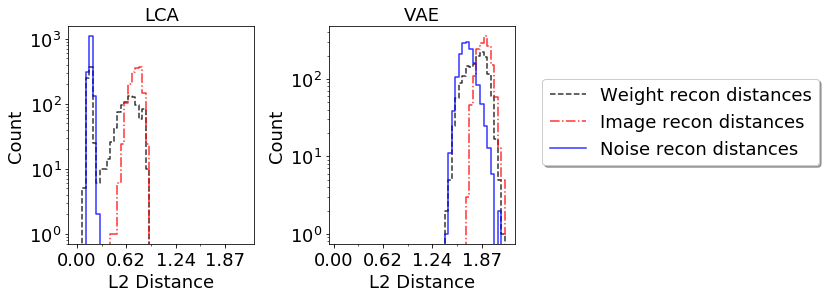

In [50]:
fontsize = 18
wspace = 0.4
line_alpha = 0.8

total_distances = lca_rec_distances+vae_rec_distances

num_bins = 50
min_dist = 0.0 # np.min(total_distances)
max_dist = np.max(total_distances)
bins = np.linspace(min_dist, max_dist, num_bins)

fig = plt.figure(figsize=(8,4))

gs = gridspec.GridSpec(1, 2, wspace=wspace)

ax = plt.subplot(gs[0])

#lca_enc_hist, bin_edges = np.histogram(lca_enc_distances, bins=bins)
#vae_enc_hist = np.histogram(vae_enc_distances, bins=bins)[0]

lca_weight_rec_hist, bin_edges = np.histogram(lca_rec_distances[:num_weights], bins=bins)
lca_image_rec_hist = np.histogram(lca_rec_distances[num_weights:num_weights+num_images], bins=bins)[0]
lca_noise_rec_hist = np.histogram(lca_rec_distances[num_weights+num_images:], bins=bins)[0]
bin_left, bin_right = bin_edges[:-1], bin_edges[1:]
bin_centers = bin_left + (bin_right - bin_left)/2
ax.plot(bin_left, lca_weight_rec_hist, color='k', alpha=line_alpha, linestyle="--", drawstyle="steps-mid", label="Weight recon distances")
ax.plot(bin_left, lca_image_rec_hist, color='r', alpha=line_alpha, linestyle="-.", drawstyle="steps-mid", label="Image recon distances")
ax.plot(bin_left, lca_noise_rec_hist, color='b', alpha=line_alpha, linestyle="-", drawstyle="steps-mid", label="Noise recon distances")
#ax.set_aspect("equal")
ax.set_xticks(bin_left[::14], minor=False)
ax.set_xticks(bin_left[::7], minor=True)
ax.xaxis.set_major_formatter(FormatStrFormatter("%0.2f"))
ax.set_yscale("log", nonposy='clip')
ax.set_xlabel("L2 Distance", fontsize=fontsize)
ax.set_ylabel("Count", fontsize=fontsize)
ax.set_title("LCA", fontsize=fontsize)
ax.tick_params("both", labelsize=fontsize)

ax = plt.subplot(gs[1])
vae_weight_rec_hist = np.histogram(vae_rec_distances[:num_weights], bins=bins)[0]
vae_image_rec_hist = np.histogram(vae_rec_distances[num_weights:num_weights+num_images], bins=bins)[0]
vae_noise_rec_hist = np.histogram(vae_rec_distances[num_weights+num_images:], bins=bins)[0]
ax.plot(bin_right, vae_weight_rec_hist, color='k', alpha=line_alpha, linestyle="--", drawstyle="steps-mid", label="Weight recon distances")
ax.plot(bin_right, vae_image_rec_hist, color='r', alpha=line_alpha, linestyle="-.", drawstyle="steps-mid", label="Image recon distances")
ax.plot(bin_right, vae_noise_rec_hist, color='b', alpha=line_alpha, linestyle="-", drawstyle="steps-mid", label="Noise recon distances")
#ax.set_aspect("equal")
ax.set_xticks(bin_left[::14], minor=False)
ax.set_xticks(bin_left[::7], minor=True)
ax.xaxis.set_major_formatter(FormatStrFormatter("%0.2f"))
ax.set_xlabel("L2 Distance", fontsize=fontsize)
ax.set_ylabel("Count", fontsize=fontsize)
ax.set_yscale("log", nonposy='clip')
ax.set_title("VAE", fontsize=fontsize)
ax.tick_params("both", labelsize=fontsize)

ax.legend(fontsize=fontsize, fancybox=True, shadow=True, bbox_to_anchor=(1.1, 0.8))

plt.show()

fig.savefig(lca_analyzer.analysis_out_dir+"/vis/network_noise_perturbation_hist.png")
fig.savefig(vae_analyzer.analysis_out_dir+"/vis/network_noise_perturbation_hist.png")

### END Gaussian ball perturbation analysis

In [ ]:
neuron_angles = analyzer.neuron_angles(analyzer.bf_stats) * (180/np.pi)

In [ ]:
angle_heatmap_fig = pf.plot_weight_angle_heatmap(neuron_angles, angle_min=0, angle_max=180,
  title="Angles Between Neurons", figsize=(8,8))
angle_heatmap_fig.savefig(analyzer.analysis_out_dir+"/vis/neuron_angle_heatmap.png")

In [ ]:
angle_hist_fig = pf.plot_weight_angle_histogram(neuron_angles, num_bins=50, angle_min=0, angle_max=180, figsize=(8,8))
angle_hist_fig.savefig(analyzer.analysis_out_dir+"/vis/neuron_angle_histogram.png")

In [ ]:
angle_neighbor_fig = pf.plot_weight_nearest_neighbor_histogram(neuron_angles, num_bins=25, angle_min=0, angle_max=90, figsize=(8,8))
angle_neighbor_fig.savefig(analyzer.analysis_out_dir+"/vis/neuron_neighbor_histogram.png")

In [ ]:
#min_angle = 0.5
#max_angle = 50

min_angle = 50
max_angle = 60

#min_angle = 89
#max_angle = 91

#min_angle = 100
#max_angle = 180

vectors = np.argwhere(np.logical_and(neuron_angles<max_angle, neuron_angles>min_angle))
print("num vectors = ", vectors.shape[0])

if vectors.shape[0] > 0:
  print("min angle = ", np.min(neuron_angles[vectors[:,0], vectors[:,1]]), " rad")
  print("min angle is at index ", np.argmin(neuron_angles[vectors[:,0], vectors[:,1]]))

  vector_id = 11 #LCA: 18, 26, 29, 30, 39, 48, 59! #[50,60]
  bf_id0 = vectors[vector_id, 0]#max_indices[0]
  bf_id1 = vectors[vector_id, 1]#max_indices[1]
  print("BF indices = [",bf_id0,", ",bf_id1,"]")

  fig, ax = plt.subplots(2)
  ax[0] = pf.clear_axis(ax[0])
  ax[0].imshow(analyzer.bf_stats["basis_functions"][bf_id0], cmap="Greys_r")
  ax[0].set_title(str(bf_id0))
  ax[1] = pf.clear_axis(ax[1])
  ax[1].imshow(analyzer.bf_stats["basis_functions"][bf_id1], cmap="Greys_r")
  ax[1].set_title(str(bf_id1))

  print("vector angle\t= ", neuron_angles[bf_id0, bf_id1]*(np.pi/180), " rad\n\t\t= ", neuron_angles[bf_id0, bf_id1], " deg")
  bf1 = analyzer.bf_stats["basis_functions"][bf_id0].reshape((analyzer.model_params.patch_edge_size**2))
  bf2 = analyzer.bf_stats["basis_functions"][bf_id1].reshape((analyzer.model_params.patch_edge_size**2))
  bf1_norm = np.linalg.norm(bf1)
  bf2_norm = np.linalg.norm(bf2)
  print("bf1 norm = ", bf1_norm)
  print("bf2 norm = ", bf2_norm)
  bf1 /= bf1_norm
  bf2 /= bf2_norm
else:
  assert False

In [ ]:
num_imgs = int(228**2)

x_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
y_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
X_mesh, Y_mesh = np.meshgrid(x_pts, y_pts)
proj_datapoints = np.stack([X_mesh.reshape(num_imgs), Y_mesh.reshape(num_imgs)], axis=1)

proj_matrix, v = analyzer.bf_projections(bf1, bf2)
proj_neuron1 = np.dot(proj_matrix, bf1).T
proj_neuron2 = np.dot(proj_matrix, bf2).T
proj_v = np.dot(proj_matrix, v).T

datapoints = np.stack([np.dot(proj_matrix.T, proj_datapoints[data_id,:]) for data_id in range(num_imgs)]) #inject
datapoints, orig_shape = dp.reshape_data(datapoints, flatten=False)[:2]
datapoints = {"test": Dataset(datapoints, lbls=None, ignore_lbls=None, rand_state=analyzer.rand_state)}
datapoints = analyzer.model.preprocess_dataset(datapoints,
  params={"whiten_data":analyzer.model_params.whiten_data,
  "whiten_method":analyzer.model_params.whiten_method})
datapoints = analyzer.model.reshape_dataset(datapoints, analyzer.model_params)
datapoints["test"].images /= np.max(np.abs(datapoints["test"].images))
datapoints["test"].images *= analyzer.analysis_params["input_scale"]

In [ ]:
activations = analyzer.compute_activations(datapoints["test"].images)
activity_max = np.amax(np.abs(activations)) # Rescale between -1 and 1
norm_activity = activations / (activity_max + 0.00001)

In [ ]:
#def plot_iso_response_contours(cmap, save_filename)
num_plots_y = 1
num_plots_x = 2
gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, wspace=0.5, width_ratios=[4, 1])
fig = plt.figure(figsize=(6, 6))
curve_ax = pf.clear_axis(fig.add_subplot(gs1[0]))
#cmap = plt.get_cmap('tab20b')
cmap = plt.get_cmap('viridis')
vmin = np.floor(np.min(norm_activity))#0.0
vmax = np.ceil(np.max(norm_activity))#1.0

#pts = curve_ax.scatter(proj_datapoints[:,0], proj_datapoints[:,1],
#  vmin=vmin, vmax=vmax, cmap=cmap, alpha=0.5, c=norm_activity[:, bf_id0], s=5.0)

levels = 5
contsf = curve_ax.contourf(X_mesh, Y_mesh, norm_activity[:,bf_id0].reshape(int(np.sqrt(num_imgs)), int(np.sqrt(num_imgs))),
  levels=levels, vmin=vmin, vmax=vmax, alpha=1.0, antialiased=True, cmap=cmap)

#conts = curve_ax.contour(X_mesh, Y_mesh, norm_activity[:,bf_id0].reshape(int(np.sqrt(num_imgs)), int(np.sqrt(num_imgs))),
#  levels=levels, vmin=vmin, vmax=vmax, alpha=1.0, antialiased=True, colors='w', linewidths=3)

curve_ax.arrow(0, 0, proj_neuron1[0].item(), proj_neuron1[1].item(), width=0.05, head_width=0.15,
  head_length=0.15, fc='r', ec='r')
curve_ax.arrow(0, 0, proj_neuron2[0].item(), proj_neuron2[1].item(), width=0.05, head_width=0.15,
  head_length=0.15, fc='w', ec='w')
#curve_ax.arrow(0, 0, proj_v[0].item(), proj_v[1].item(), width=0.05, head_width=0.15,
#  head_length=0.15, fc='b', ec='b')

curve_ax.set_title("Angle = "+"{:.2f}".format(neuron_angles[bf_id0, bf_id1])+" deg", fontsize=16)
curve_ax.set_ylim([-2, 2.0])
curve_ax.set_xlim([-2, 2.0])
curve_ax.set_aspect("equal")
#cbar = pf.add_colorbar_to_im(pts, aspect=20, pad_fraction=0.5, labelsize=16, ticks=[vmin, vmax])
#cbar.ax.set_yticklabels(["{:.0f}".format(vmin), "{:.0f}".format(vmax)])

gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, gs1[1], wspace=2, hspace=-0.2)
bf1_ax = pf.clear_axis(fig.add_subplot(gs2[0]))
bf1_ax.imshow(analyzer.bf_stats["basis_functions"][bf_id0], cmap="Greys_r")
bf1_ax.set_title("Primary\nBasis Function", color='r', fontsize=16)
bf2_ax = pf.clear_axis(fig.add_subplot(gs2[1]))
bf2_ax.imshow(analyzer.bf_stats["basis_functions"][bf_id1], cmap="Greys_r")
bf2_ax.set_title("Comparison\nBasis Function", color='k', fontsize=16)
fig.savefig(analyzer.analysis_out_dir+"/vis/neuron_response_contours_bf0id"+str(bf_id0)+"_bf1id"+str(bf_id1)+".png")
plt.show()

In [ ]:
test_imgs = datapoints["test"].images.reshape([int(np.sqrt(num_imgs)), int(np.sqrt(num_imgs)), 16, 16])

num_plots_y = 3
num_plots_x = 3
gs = gridspec.GridSpec(num_plots_y, num_plots_x)
fig = plt.figure(figsize=(8,8))
half_sqrt_imgs = int(np.sqrt(num_imgs)/2)
filter_indices = [(0,0), (0, half_sqrt_imgs), (0, -1),
  (half_sqrt_imgs, 0), (half_sqrt_imgs, half_sqrt_imgs), (half_sqrt_imgs, -1),
  (-1, 0), (-1, half_sqrt_imgs), (-1, -1)]
filter_idx = 0
for plot_id in  np.ndindex((num_plots_y, num_plots_x)):
  ax = pf.clear_axis(fig.add_subplot(gs[plot_id]))
  if filter_idx < num_imgs:
    ax.imshow(test_imgs[filter_indices[filter_idx][0], filter_indices[filter_idx][1], ...], cmap="Greys_r")
  filter_idx += 1
fig.suptitle("Basis Function Interpolation", y=0.95)
plt.show()

In [ ]:
var_names = ["inference/activity:0"]
test_datapoints = analyzer.analysis_params.input_scale*np.squeeze(np.stack([bf1, bf2]))
test_activations = analyzer.evaluate_model(test_datapoints, var_names)["inference/activity:0"]
print("num nonzero for bf1: ", np.count_nonzero(test_activations[0,:]))
print("num nonzero for bf2: ", np.count_nonzero(test_activations[1,:]))
fig, ax = plt.subplots(1)
ax.hist(test_activations[1,:], rwidth=0.5)
ax.set_title("Activity histogram for a basis function as input")
plt.show()

In [ ]:
#def plot_iso_response_contours(cmap, save_filename)
num_plots_y = 1
num_plots_x = 2
gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, wspace=0.5)#, width_ratios=[4, 1])
fig = plt.figure(figsize=(12, 12))
curve_ax = pf.clear_axis(fig.add_subplot(gs1[0]))
cmap = plt.get_cmap('tab20b')

pts = curve_ax.scatter(proj_datapoints[:,0], proj_datapoints[:,1], cmap=cmap, c="blue", s=0.5)
curve_ax.arrow(0, 0, proj_neuron1[0].item(), proj_neuron1[1].item(), width=0.05, head_width=0.15,
  head_length=0.15, fc='k', ec='k')
#curve_ax.arrow(0, 0, proj_neuron2[0].item(), proj_neuron2[1].item(), width=0.05, head_width=0.15,
#  head_length=0.15, fc='r', ec='r')
curve_ax.arrow(0, 0, proj_v[0].item(), proj_v[1].item(), width=0.05, head_width=0.15,
  head_length=0.15, fc='k', ec='k')
curve_ax.set_ylim([-2.0, 2.0])
curve_ax.set_xlim([-2.0, 2.0])
curve_ax.set_aspect("equal")

#img_idx = -1
#pts = curve_ax.scatter(proj_datapoints[img_idx, 0], proj_datapoints[img_idx, 1], cmap=cmap, c="red", s=50.0)

def plt_img(axis, img_idx):
  axis.imshow(datapoints["test"].images[img_idx, ...].reshape((int(np.sqrt(analyzer.model.num_pixels)),
    int(np.sqrt(analyzer.model.num_pixels)))), cmap="Greys_r")
  axis.set_title("Position "+str(img_idx))
  return axis

img_idx = 0
gs2 = gridspec.GridSpecFromSubplotSpec(3, 3, gs1[1])#, wspace=2, hspace=-0.2)
bf1_ax = plt_img(pf.clear_axis(fig.add_subplot(gs2[0])), img_idx)

img_idx = 49
bf2_ax = plt_img(pf.clear_axis(fig.add_subplot(gs2[1])), img_idx)

img_idx = 99
bf3_ax = plt_img(pf.clear_axis(fig.add_subplot(gs2[2])), img_idx)

img_idx = 5000
bf4_ax = plt_img(pf.clear_axis(fig.add_subplot(gs2[3])), img_idx)

img_idx = 5049
bf5_ax = plt_img(pf.clear_axis(fig.add_subplot(gs2[4])), img_idx)

img_idx = 5099
bf6_ax = plt_img(pf.clear_axis(fig.add_subplot(gs2[5])), img_idx)

img_idx = -99
bf7_ax = plt_img(pf.clear_axis(fig.add_subplot(gs2[6])), img_idx)

img_idx = -49
bf8_ax = plt_img(pf.clear_axis(fig.add_subplot(gs2[7])), img_idx)

img_idx = -1
bf9_ax = plt_img(pf.clear_axis(fig.add_subplot(gs2[8])), img_idx)

fig.savefig(analyzer.analysis_out_dir+"/vis/projection_visualization"+str(bf_id0)+"_bf1id"+str(bf_id1)+".png")
plt.show()

In [ ]:
x_target = x_pts[int(6*np.sqrt(num_imgs)/8)] # find a location to take a slice
slice_indices = np.where(proj_datapoints[:,0]==x_target)[0]
x_vals = proj_datapoints[slice_indices,:][:,1] # slice grid

In [ ]:
num_comparison_points = 8
num_plots_y = 1
num_plots_x = 1+num_comparison_points
gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, hspace=0.6, wspace=0.6)
fig = plt.figure(figsize=(15, 6))
for yid in range(num_plots_y):
  ax1 = fig.add_subplot(gs1[yid, 0])

  cmap = plt.get_cmap('viridis')
  vmin = 0.0
  vmax = 1.0
  rank_indices = np.argsort(norm_activity[slice_indices, bf_id0])
  slice_datapoints = proj_datapoints[slice_indices,:]
  pts = ax1.scatter(slice_datapoints[rank_indices,0],
    slice_datapoints[rank_indices,1], vmin=vmin, vmax=vmax,
    cmap=cmap, c=norm_activity[slice_indices, bf_id0][rank_indices], s=1.0)
  ax1.arrow(0, 0, proj_neuron1[0].item(), proj_neuron1[1].item(),
    width=0.05, head_width=0.15, head_length=0.15, fc='r', ec='r')
  ax1.arrow(0, 0, proj_neuron2[0].item(), proj_neuron2[1].item(),
    width=0.05, head_width=0.15, head_length=0.15, fc='k', ec='k')
  ax1.set_xlim([-2,2])
  ax1.set_ylim([-2,2])
  ax1.set_aspect("equal")
  ax1.set_title("bf1id="+str(bf_id1))

  y_indices = np.arange(slice_indices.size)[::int(slice_indices.size/num_comparison_points)]
  if y_indices.size < num_comparison_points:
    y_indices.append(-1)
  for pid, xid in enumerate(range(1, num_plots_x)):
    ax = pf.clear_axis(fig.add_subplot(gs1[yid, xid]))
    images = datapoints["test"].images[slice_indices, :]
    ax.imshow(images[y_indices[pid], :].reshape([analyzer.model_params.patch_edge_size,
      analyzer.model_params.patch_edge_size]), cmap="Greys_r")
    subfig_title = ("({:.1f}, ".format(proj_datapoints[slice_indices,:][y_indices[pid],0])
      +"{:.1f})".format(proj_datapoints[slice_indices,:][y_indices[pid],1]))
    ax.set_title(subfig_title)
fig.savefig(analyzer.analysis_out_dir+"/vis/single_slice_example_bf0id"+str(bf_id0)+".png")
plt.show()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,8))
ax[0].plot(x_vals, norm_activity[slice_indices, bf_id0], color='b', alpha=0.3) # x_vals in the 2-D grid are plotted along the x axis
ax[0].set_title("Normalized Responses to Orthogonal Inputs", y=1.08)
ax[0].set_ylabel("Normalized Activation", fontsize=14)
ax[0].set_xlabel("Distance from Basis Function", fontsize=14)
ax[0].grid(True)
ax[0].set_ylim([0.0, 1.0])
ax[0].set_xlim([np.min(x_vals), np.max(x_vals)])
ax[0].set_aspect((np.max(x_vals)-np.min(x_vals)))
ax[0].tick_params(labelsize=14)
ax[1] = pf.clear_axis(ax[1])
ax[1].imshow(analyzer.bf_stats["basis_functions"][bf_id0], cmap="Greys_r")
ax[1].set_title("Basis Function", y=1.08)
fig.savefig(analyzer.analysis_out_dir+"/vis/bf_example_curvature_bf0id"+str(bf_id0)+".png")
plt.show()

Here we can either:
  * Compute a unit vector that is in the same plane as a given basis function pair (B1,B2) and is orthogonal to B1, where B1 is the target basis for comparison and B2 is selected from all other bases.
  * Construct a line of data points in this plane
  * Project the data points into image space, compute activations, plot activations

or

  * Construct the set of unit-length bases that are orthogonal to B1 (there should be B1.size-1 of them)
  * Construct a line of data points in each plane defined by B1 and a given orthogonal basis
  * Project the data points into image space, compute activations, plot activations

In [ ]:
pop_num_imgs = 100

orthogonal_list = [idx for idx in range(analyzer.bf_stats["num_outputs"]) if idx != bf_id0]#[bf_id1]
num_orthogonal = len(orthogonal_list)

pop_x_pts = np.linspace(-2.0, 2.0, int(pop_num_imgs))
pop_y_pts = np.linspace(-2.0, 2.0, int(pop_num_imgs))
pop_X, pop_Y = np.meshgrid(pop_x_pts, pop_y_pts)
pop_proj_datapoints = np.stack([pop_X.reshape(pop_num_imgs**2), pop_Y.reshape(pop_num_imgs**2)], axis=1) # construct a grid
x_target = pop_x_pts[int(6*pop_num_imgs/8)] # find a location to take a slice
slice_indices = np.where(pop_proj_datapoints[:,0]==x_target)[0]
pop_proj_datapoints = pop_proj_datapoints[slice_indices,:] # slice grid

pop_datapoints = [None,]*num_orthogonal
pop_proj_neurons = [None,]*num_orthogonal
for pop_idx, tmp_bf_id1 in enumerate(orthogonal_list):
  tmp_bf2 = analyzer.bf_stats["basis_functions"][tmp_bf_id1].reshape((analyzer.model_params.patch_edge_size**2))
  tmp_bf2 /= np.linalg.norm(tmp_bf2)
  tmp_proj_matrix, v = analyzer.bf_projections(bf1, tmp_bf2) 
  pop_proj_neurons[pop_idx] = (np.dot(tmp_proj_matrix, bf1).T, np.dot(tmp_proj_matrix, tmp_bf2).T)
  pop_datapoints[pop_idx] = np.dot(pop_proj_datapoints, tmp_proj_matrix)#[slice_indices,:]

pop_datapoints = np.reshape(np.stack(pop_datapoints, axis=0),
  [num_orthogonal*pop_num_imgs, analyzer.model_params.patch_edge_size**2])

pop_datapoints = dp.reshape_data(pop_datapoints, flatten=False)[0]
pop_datapoints = {"test": Dataset(pop_datapoints, lbls=None, ignore_lbls=None, rand_state=analyzer.rand_state)}
pop_datapoints = analyzer.model.preprocess_dataset(pop_datapoints,
  params={"whiten_data":analyzer.model_params.whiten_data,
  "whiten_method":analyzer.model_params.whiten_method})
pop_datapoints = analyzer.model.reshape_dataset(pop_datapoints, analyzer.model_params)
pop_datapoints["test"].images /= np.max(np.abs(pop_datapoints["test"].images))
pop_datapoints["test"].images *= analyzer.analysis_params["input_scale"]

In [ ]:
pop_activations = analyzer.compute_activations(pop_datapoints["test"].images)[:, bf_id0]
pop_activations = pop_activations.reshape([num_orthogonal, pop_num_imgs])
pop_norm_activity = pop_activations / np.amax(np.abs(pop_activations))

In [ ]:
num_comparison_points = 8
num_plots_y = 4
num_plots_x = 1+num_comparison_points
gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, hspace=0.6, wspace=0.3)
fig = plt.figure(figsize=(15, 6))
for yid in range(num_plots_y):
  orthog_idx = np.random.choice(np.arange(num_orthogonal), replace=False)
  ax1 = fig.add_subplot(gs1[yid, 0])
  pop_orthog_activity = pop_norm_activity[orthog_idx, :] 

  cmap = plt.get_cmap('viridis')
  
  vmin = np.floor(np.min(pop_orthog_activity))
  vmax = np.ceil(np.max(pop_orthog_activity))
  rank_indices = np.argsort(pop_orthog_activity)
  pts = ax1.scatter(pop_proj_datapoints[rank_indices,0], pop_proj_datapoints[rank_indices,1],
    vmin=vmin, vmax=vmax, cmap=cmap, c=pop_orthog_activity[rank_indices], s=1.0)
  ax1.arrow(0, 0, pop_proj_neurons[orthog_idx][0][0].item(), pop_proj_neurons[orthog_idx][0][1].item(),
    width=0.05, head_width=0.15, head_length=0.15, fc='r', ec='r')
  ax1.arrow(0, 0, pop_proj_neurons[orthog_idx][1][0].item(), pop_proj_neurons[orthog_idx][1][1].item(),
    width=0.05, head_width=0.15, head_length=0.15, fc='k', ec='k')
  ax1.set_xlim([-2,2])
  ax1.set_ylim([-2,2])
  ax1.set_aspect("equal")
  ax1.set_title("bfid="+str(orthogonal_list[orthog_idx]))

  y_indices = np.arange(pop_num_imgs)[::int(pop_num_imgs/num_comparison_points)]
  if y_indices.size < num_comparison_points:
    y_indices.append(-1)
  for pid, xid in enumerate(range(1, num_plots_x)):
    ax = pf.clear_axis(fig.add_subplot(gs1[yid, xid]))
    imid = np.ravel_multi_index((orthog_idx, y_indices[pid]), (num_orthogonal, pop_num_imgs))
    ax.imshow(pop_datapoints["test"].images[imid, ...].reshape([analyzer.model_params.patch_edge_size,
      analyzer.model_params.patch_edge_size]), cmap="Greys_r")
    subfig_title = ("({:.1f}, ".format(pop_proj_datapoints[y_indices[pid],0])
      +"{:.1f})".format(pop_proj_datapoints[y_indices[pid],1]))
    ax.set_title(subfig_title)
fig.savefig(analyzer.analysis_out_dir+"/vis/orthogonal_slice_examples_bf0id"+str(bf_id0)+".png")
plt.show()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,8))
for orthog_idx in range(num_orthogonal):
 ax[0].plot(pop_proj_datapoints[:,1], pop_norm_activity[orthog_idx, :], color='b', alpha=0.05)
ax[0].set_title("Normalized Responses\nto Orthogonal Inputs", y=1.08, fontsize=16)
ax[0].set_ylabel("Normalized Activation", fontsize=16)
ax[0].set_xlabel("Distance from Basis Function", fontsize=16)
ax[0].grid(True)
ax[0].set_ylim([0.0, 1.0])
ax[0].set_xlim([np.min(x_vals), np.max(x_vals)])
for tick in ax[0].xaxis.get_major_ticks():
  tick.label.set_fontsize(14) 
for tick in ax[0].yaxis.get_major_ticks():
  tick.label.set_fontsize(14) 
ax[0].set_aspect((np.max(x_vals)-np.min(x_vals)))#/(np.max(pop_norm_activity)-np.min(pop_norm_activity)))
ax[0].tick_params(labelsize=14)
ax[1] = pf.clear_axis(ax[1])
ax[1].imshow(analyzer.bf_stats["basis_functions"][bf_id0], cmap="Greys_r")
ax[1].set_title("Basis Function", y=1.08)
fig.savefig(analyzer.analysis_out_dir+"/vis/bf_curvatures_bf0id"+str(bf_id0)+".png")
plt.show()

In [ ]:
coeffs = [np.polynomial.polynomial.polyfit(pop_proj_datapoints[:,1], pop_norm_activity[orthog_idx,:], deg=2)
  for orthog_idx in range(num_orthogonal)]
fits = [np.polynomial.polynomial.polyval(pop_proj_datapoints[:,1], coeff) for coeff in coeffs]
curvatures = [np.polyder(fit, m=2) for fit in fits]

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,8))
for orthog_idx in range(num_orthogonal):
  ax[0].plot(pop_proj_datapoints[:,1], fits[orthog_idx], color='r', alpha=0.05)
ax[0].set_title("Polynomial Fit Responses\nto Orthogonal Inputs", y=1.08, fontsize=16)
ax[0].set_ylabel("Normalized Activation", fontsize=16)
ax[0].set_xlabel("Distance from Basis Function", fontsize=16)
for tick in ax[0].xaxis.get_major_ticks():
  tick.label.set_fontsize(14) 
for tick in ax[0].yaxis.get_major_ticks():
  tick.label.set_fontsize(14) 
ax[0].grid(True)
ax[0].set_ylim([0.0, 1.1])
ax[0].set_xlim([np.min(pop_proj_datapoints[:,1]), np.max(pop_proj_datapoints[:,1])])
ax[0].set_aspect((np.max(pop_proj_datapoints[:,1])-np.min(pop_proj_datapoints[:,1])))
ax[0].tick_params(labelsize=14)
ax[1] = pf.clear_axis(ax[1])
ax[1].imshow(analyzer.bf_stats["basis_functions"][bf_id0], cmap="Greys_r")
ax[1].set_title("Basis Function", y=1.08)
fig.savefig(analyzer.analysis_out_dir+"/vis/fit_curvatures_bf0id"+str(bf_id0)+".png")
plt.show()

In [ ]:
from matplotlib.ticker import FormatStrFormatter

curvatures = np.stack(coeffs, axis=0)[:,2]

num_bins = 50
bins = np.linspace(np.amin(curvatures), np.amax(curvatures), num_bins)
hist, bin_edges = np.histogram(curvatures.flatten(), bins)
bin_left, bin_right = bin_edges[:-1], bin_edges[1:]
bin_centers = bin_left + (bin_right - bin_left)/2

fig, ax = plt.subplots(1, figsize=(5,5))
ax.bar(bin_centers, hist, width=0.001, log=False, align="center")
ax.set_xticks(bin_left, minor=True)
ax.set_xticks(bin_left[::8], minor=False)
ax.xaxis.set_major_formatter(FormatStrFormatter("%0.2f"))
for tick in ax.xaxis.get_major_ticks():
  tick.label.set_fontsize(16) 
for tick in ax.yaxis.get_major_ticks():
  tick.label.set_fontsize(16) 

ax.set_title("Histogram of Curvatures", fontsize=16)
ax.set_xlabel("Second Order Polyfit Coefficient\n(Negative Indicates Exo-Origin)", fontsize=16)
ax.set_ylabel("Count", fontsize=16)
fig.savefig(analyzer.analysis_out_dir+"/vis/histogram_of_curvatures_bf0id"+str(bf_id0)+".png")
plt.show()

In [ ]:
concavity = np.asarray([np.sign(coeffs[idx][2]) for idx in range(len(coeffs))])
num_endo = np.sum(concavity>0)
endo_indices = np.where(concavity>0)[0]
num_exo = np.sum(concavity<0)
exo_indices = np.where(concavity<0)[0]
print("num >0 (tolerant/invariant/endo-origin):", num_endo,
  "\nnum <0 (selective/equivariant/exo-origin):", num_exo)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for idx in endo_indices:
  ax.plot(pop_proj_datapoints[:,1], fits[idx], color="g", alpha=0.3)
ax.set_title("Normalized Responses to Invariant Inputs")
ax.set_ylabel("Normalized Activation", fontsize=14)
ax.set_xlabel("Distance from Basis Function", fontsize=14)
ax.grid(True)
ax.set_ylim([0.0,1.0])
ax.set_xlim([np.min(pop_proj_datapoints[:,1]), np.max(pop_proj_datapoints[:,1])])
ax.set_aspect((np.max(pop_proj_datapoints[:,1])-np.min(pop_proj_datapoints[:,1])))
ax.tick_params(labelsize=14)
fig.savefig(analyzer.analysis_out_dir+"/vis/fit_invariant_curvatures.png")
plt.show()

In [ ]:
max_exo_index = np.argmin(concavity) # image index with the maximum exo-origin curviture
max_endo_index = np.argmax(concavity) # image index with the maximum endo-origin curviture

In [ ]:
num_comparison_points = 20
num_plots_y = 1
num_plots_x = num_comparison_points
gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, hspace=0.6, wspace=0.3)
fig = plt.figure(figsize=(30, 6))

y_indices = np.arange(pop_num_imgs)[::int(pop_num_imgs/num_comparison_points)]
if y_indices.size < num_comparison_points:
  y_indices.append(-1)
for pid, xid in enumerate(range(num_plots_x)):
  ax = pf.clear_axis(fig.add_subplot(gs1[0, xid]))
  imid = np.ravel_multi_index((max_endo_index, y_indices[pid]), (num_orthogonal, pop_num_imgs))
  ax.imshow(pop_datapoints["test"].images[imid, ...].reshape([analyzer.model_params.patch_edge_size,
    analyzer.model_params.patch_edge_size]), cmap="Greys_r")
  subfig_title = ("({:.1f}, ".format(pop_proj_datapoints[y_indices[pid],0])
    +"{:.1f})".format(pop_proj_datapoints[y_indices[pid],1]))
  ax.set_title(subfig_title)
fig.suptitle("Images with Maximum Endo-Origin (Tolerant) Curvature", fontsize=24, y=0.7)
fig.savefig(analyzer.analysis_out_dir+"/vis/max_endo_images.png")
plt.show()

In [ ]:
num_comparison_points = 20
num_plots_y = 1
num_plots_x = num_comparison_points
gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, hspace=0.6, wspace=0.3)
fig = plt.figure(figsize=(30, 6))

y_indices = np.arange(pop_num_imgs)[::int(pop_num_imgs/num_comparison_points)]
if y_indices.size < num_comparison_points:
  y_indices.append(-1)
for pid, xid in enumerate(range(num_plots_x)):
  ax = pf.clear_axis(fig.add_subplot(gs1[0, xid]))
  imid = np.ravel_multi_index((max_exo_index, y_indices[pid]), (num_orthogonal, pop_num_imgs))
  ax.imshow(pop_datapoints["test"].images[imid, ...].reshape([analyzer.model_params.patch_edge_size,
    analyzer.model_params.patch_edge_size]), cmap="Greys_r")
  subfig_title = ("({:.1f}, ".format(pop_proj_datapoints[y_indices[pid],0])
    +"{:.1f})".format(pop_proj_datapoints[y_indices[pid],1]))
  ax.set_title(subfig_title)
fig.suptitle("Images with Maximum Exo-Origin (Selective) Curvature", fontsize=24, y=0.7)
fig.savefig(analyzer.analysis_out_dir+"/vis/max_exo_images.png")
plt.show()